In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
model_reg=tf.keras.models.load_model('models/combined_model_ann.h5')
model_cls=tf.keras.models.load_model('models/combined_model_cls_ann.h5')

In [3]:
# "temperature", "dwpt", "wspd", "wdir", "prcp", "rhum", "pres","day_of_week", "hour_of_day", "season", "month","is_holiday", "is_weekend", "population","solar_generation"


def predict_for_date(
    date,
    temperature,
    solar_generation,
    hour_of_day,
    is_holiday,
    # dwpt,
    wspd,
    # wdir,
    prcp,
    rhum,
    # pres,
    day_of_week,
    season,
    # month,
    is_weekend,
    model_clf,
    model_reg,
    le,
    # scaler,
):
    # Create a DataFrame for the input data
    new_data = pd.DataFrame(
        {
            "day_of_week": [day_of_week],
            "hour_of_day": [hour_of_day],
            "is_weekend": [is_weekend],
            "temperature": [temperature],
            "is_holiday": [is_holiday],
            # "dwpt": [dwpt],
            "wspd": [wspd],
            # "wdir": [wdir],
            "prcp": [prcp],
            "rhum": [rhum],
            # "pres": [pres],
            "season": [season],
            # "month": [month],
            "solar_generation": [solar_generation],
        }
    )

    # Scale the input data
    # new_data_scaled = scaler.transform(new_data)

    # Make predictions using the classification model
    predicted_class_label = model_clf.predict(
        new_data
    )  # Predict the class label
    predicted_compensation_method = le.inverse_transform(
        np.argmax(predicted_class_label, axis=1)
    )

    # Make predictions using the regression model
    predicted_peak_supply = model_reg.predict(
        new_data
    )  # Predict the peak supply needed

    return {
        "date": date,
        "hour_of_day": hour_of_day,
        "compensation_method": predicted_compensation_method[0],
        "peak_supply_needed": predicted_peak_supply[0],
    }


def generate_24_hour_predictions(
    timestamp,
    temperature,
    solar_generation,
    is_holiday,
    # dwpt,
    wspd,
    # wdir,
    prcp,
    rhum,
    # pres,
    day_of_week,
    season,
    # month,
    is_weekend,
    model_clf,
    model_reg,
    le,
    # scaler,
):

    results = []

    hour = timestamp.hour

    prediction = predict_for_date(
        timestamp,
        temperature,
        solar_generation,
        hour,
        is_holiday,
        # dwpt,
        wspd,
        # wdir,
        prcp,
        rhum,
        # pres,
        day_of_week,
        season,
        # month,
        is_weekend,
        model_clf,
        model_reg,
        le,
        # scaler,
    )
    results.append(prediction)

    df_predictions = pd.DataFrame(results)

    return df_predictions

In [4]:
test_dataset=pd.read_csv('dataset/test_dataset_2024.csv')
test_dataset.head()
test_dataset['timestamp']=pd.to_datetime(test_dataset['timestamp'])

In [5]:
def generate_year_predictions(test_dataset, rf_clf, rf_reg, le):

    all_predictions = []

    for _, row in test_dataset.iterrows():
        timestamp = pd.to_datetime(row["timestamp"])
        temperature = row["temperature"]
        solar_generation = row["solar_generation"]
        is_holiday = row["is_holiday"]
        # dwpt = row["dwpt"]
        wspd = row["wspd"]
        # wdir = row["wdir"]
        prcp = row["prcp"]
        rhum = row["rhum"]
        # pres = row["pres"]
        day_of_week = row["day_of_week"]
        season = row["season"]
        # month = row["month"]
        is_weekend = row["is_weekend"]

        # Generate predictions for each hour of the day
        daily_predictions = generate_24_hour_predictions(
            timestamp,
            temperature,
            solar_generation,
            is_holiday,
            # dwpt,
            wspd,
            # wdir,
            prcp,
            rhum,
            # pres,
            day_of_week,
            season,
            # month,
            is_weekend,
            rf_clf,
            rf_reg,
            le,
            # scaler
        )
        all_predictions.append(daily_predictions)

    # Combine all daily predictions into one DataFrame
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)

    return df_all_predictions

In [6]:
import pickle

with open("models/label_encoder_ann.pkl", "rb") as f:
    le = pickle.load(f)
    
with open("models/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [7]:
df_year_predictions = generate_year_predictions(
    test_dataset,
    model_cls,
    model_reg,
    le,
)

1/1 [==============================] - 0s 20ms/step


In [8]:
df_year_predictions['peak_supply_needed'] = df_year_predictions['peak_supply_needed'].apply(lambda x: x[0])

In [9]:
df_year_predictions['compensation_method'].unique()

array(['Lower Power Supply'], dtype=object)

In [10]:
# df_year_predictions.to_csv('dataset/predictions_2024-result-1.csv',index=False)
df_train=pd.read_csv("dataset/24-hours Delhi Power Consumption dataset.csv")

In [11]:
df_year_predictions

,date,hour_of_day,compensation_method,peak_supply_needed
0,2024-01-01 00:00:00,0,Lower Power Supply,205089.703125
1,2024-01-01 01:00:00,1,Lower Power Supply,216212.343750
2,2024-01-01 02:00:00,2,Lower Power Supply,222281.218750
3,2024-01-01 03:00:00,3,Lower Power Supply,208561.562500
4,2024-01-01 04:00:00,4,Lower Power Supply,221020.937500
...,...,...,...,...
7403,2024-11-04 11:00:00,11,Lower Power Supply,148540.906250
7404,2024-11-04 12:00:00,12,Lower Power Supply,153298.218750
7405,2024-11-04 13:00:00,13,Lower Power Supply,166703.234375
7406,2024-11-04 14:00:00,14,Lower Power Supply,186286.703125


C:\Users\ariel\AppData\Local\Temp\ipykernel_13336\3569628575.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_train.head(100), x='hour_of_day', y='load', palette='Set1')


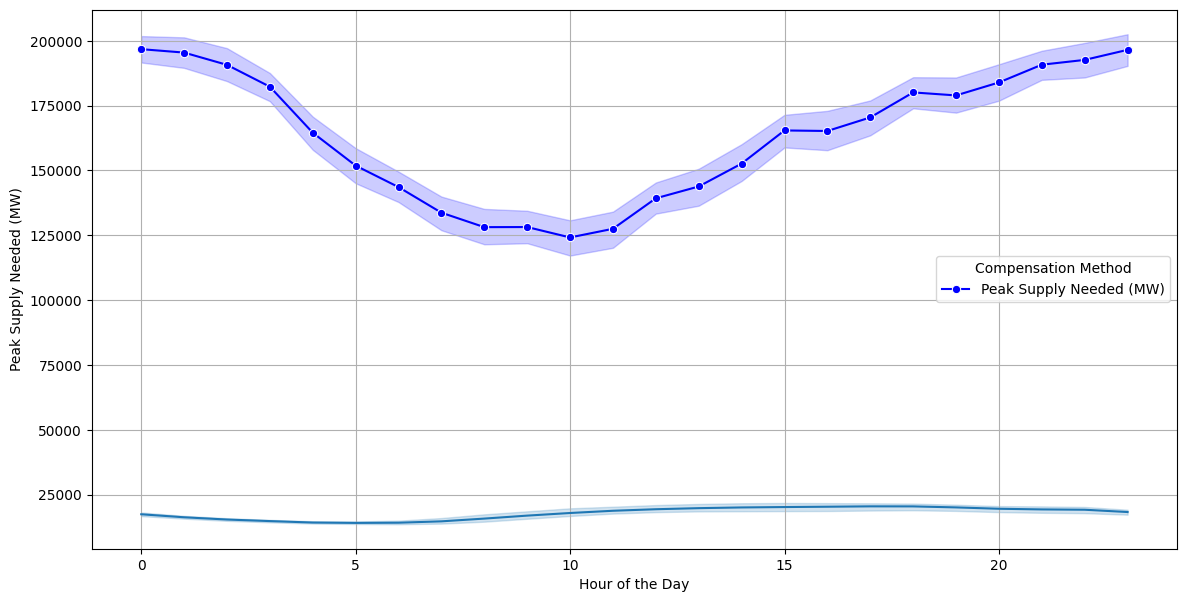

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_predictions(df_predictions):
    plt.figure(figsize=(14, 7))

    sns.lineplot(data=df_predictions, x='hour_of_day', y='peak_supply_needed', marker='o', color='blue', label='Peak Supply Needed (MW)')
    
    sns.lineplot(data=df_train.head(100), x='hour_of_day', y='load', palette='Set1')

    # plt.title('Hourly Predictions for {}'.format(df_predictions['date'][0]))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Peak Supply Needed (MW)')
    plt.legend(title='Compensation Method')
    plt.grid(True)
    plt.show()

plot_predictions(df_year_predictions)